# Advanced Lane Finding

### 1- Camera Calebraion and Distortion Correction : 

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

def calibrate_distort_cam(images, test_image_name='test', corners_w=9, corners_h=6):
    """
    @param: images , array of images paths ['folder//image_name.jpg',..]
    """
    # prepare object points, 
    # 6*8 length arrays, length=3 each , like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((corners_w*corners_h,3), np.float32)
    objp[:,:2] = np.mgrid[0:corners_w, 0:corners_h].T.reshape(-1,2)#create grid of 2 arrays, then reshape to 6*9, then replace values in objp
    """output :
    [[ 0.  0.  0.]
     [ 1.  0.  0.]
     ...
     [ 7.  5.  0.]
     [ 8.  5.  0.]]
    """
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)#read image
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)#convert to gray
        
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('chess board', fontsize=20)
    # Draw and display the corners of an image
    cv2.drawChessboardCorners(img, (9,6), corners, ret)
    
    ax2.imshow(img)
    ax2.set_title('chess board inner corners', fontsize=20)
    #calibration 
    test_img = cv2.imread('camera_cal/'+test_image_name+'.jpg')
    img_size = (test_img.shape[1], test_img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
        
    # Test undistortion on an image
    undistorted_img = cv2.undistort(test_img, mtx, dist, None, mtx)
    #display
    ax3.imshow(test_img)
    ax3.set_title('Original Image', fontsize=20)
    ax4.imshow(undistorted_img)
    ax4.set_title('Undistorted Image', fontsize=20)
    
    return mtx, dist


In [3]:
import pickle
def save_calibration(mtx, dist, folder='camera_cal'):
    # Save the camera calibration result for later use
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( folder+"/wide_dist_pickle.p", "wb" ) )

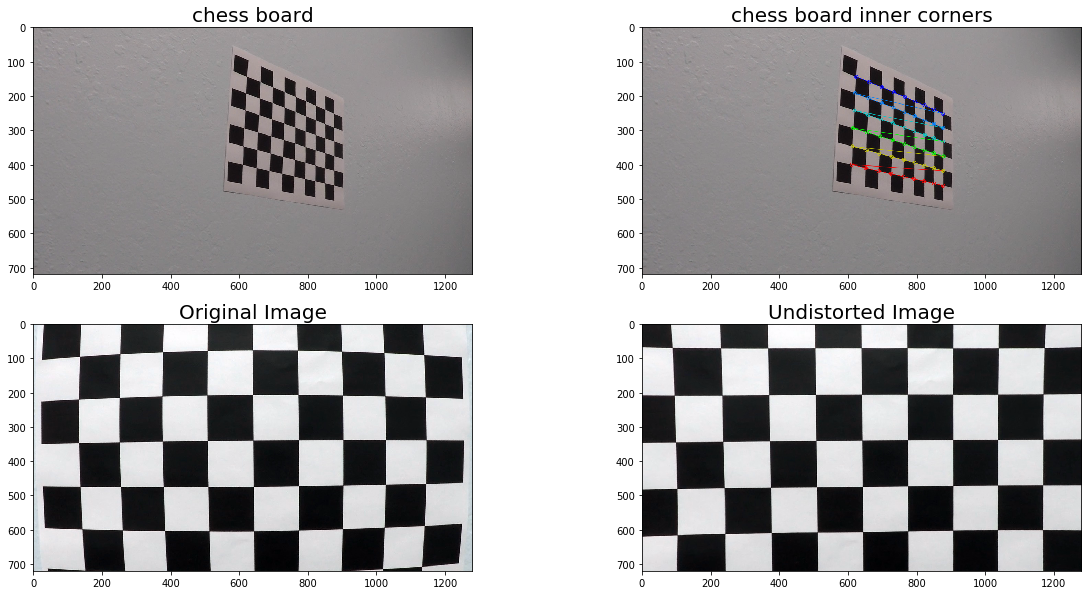

In [4]:
# Make a list of calibration images urls
images = glob.glob('camera_cal/calibration*.jpg')
mtx, dist = calibrate_distort_cam(images)
    
save_calibration(mtx, dist)



### 2-  Color/Gradient Threshold

In [5]:
import matplotlib.image as mpimg
def abs_sobel_thresh(s_channel, orient='x', sobel_kernel=3, s_thresh=(0, 255)):
    
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'y':
        sobel = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel) # Take the derivative in y
    else:
        sobel = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # Take the derivative in x
    
    abs_sobel = np.absolute(sobel) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Threshold x gradient
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= s_thresh[0]) & (scaled_sobel <= s_thresh[1])] = 1
    
    return sobel_binary

In [6]:
def s_hls_thresh(s_channel, s_thresh=(0, 255)):
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Return the result
    return s_binary

In [7]:
def pipeline_gradiant_thresh(img, s_thresh=(170, 255), sobel_thresh=(30, 70), do_plot=False):  
    #img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    # equalize the histogram of the Y channel
    #img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    #img_yuv[:,:,2] = cv2.equalizeHist(img_yuv[:,:,2])
    # convert the YUV image back to RGB format
    #img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    
    # Choose a Sobel kernel size
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    #hsv = cv2.cvtColor(img_contrast, cv2.COLOR_RGB2HLS).astype(np.float)
    
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]
    # Apply each of the thresholding functions
    sobel_x_binary = abs_sobel_thresh(l_channel, orient='x', sobel_kernel=1, s_thresh=sobel_thresh)
    s_binary = s_hls_thresh(s_channel, s_thresh=s_thresh)
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sobel_x_binary), sobel_x_binary, s_binary))
    
    if do_plot:
        f, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(24, 13))
        f.tight_layout()
        f.suptitle("Sobel X with L channel & S channel thresholded :", fontsize=30)

        ax1.imshow(img)
        ax1.set_title('Original image', fontsize=20)

        ax4.imshow(img)
        ax4.set_title('Original image', fontsize=20)

        ax2.imshow(l_channel)
        ax2.set_title('L channel of image HLS', fontsize=20)

        ax5.imshow(s_channel)
        ax5.set_title('S channel of image HLS', fontsize=20)

        ax3.imshow(sobel_x_binary, cmap='gray')
        ax3.set_title('Binary Sobel X', fontsize=20)

        ax6.imshow(s_binary, cmap='gray')
        ax6.set_title('S Channel Binary', fontsize=20)
    return color_binary, sobel_x_binary , s_binary 

In [8]:
def compine_sobel_schannel(sobelx_binary, schannel_binary, result, do_plot=False):
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sobelx_binary)
    combined_binary[(schannel_binary == 1) | (sobelx_binary == 1)] = 1
    
    if do_plot:
        f, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
        f.tight_layout()
        f.suptitle("Combined Results :", fontsize=30)
        ax1.imshow(result)
        ax1.set_title('Pipeline Result', fontsize=20)

        ax2.imshow(combined_binary, cmap='gray')
        ax2.set_title('Combined Binary', fontsize=20)
    return combined_binary

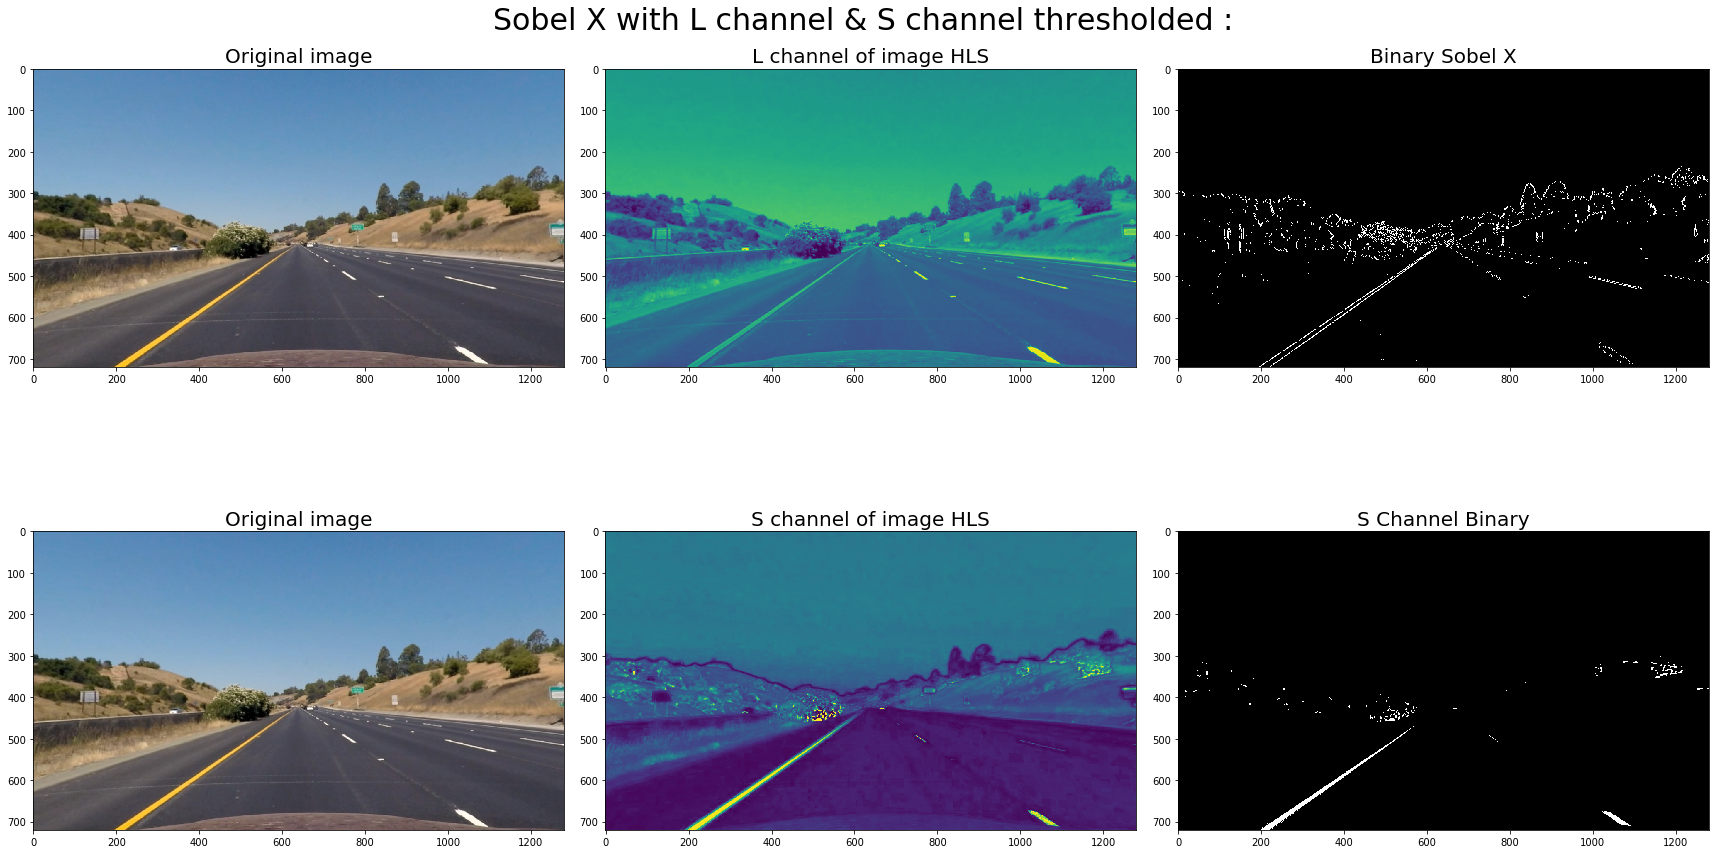

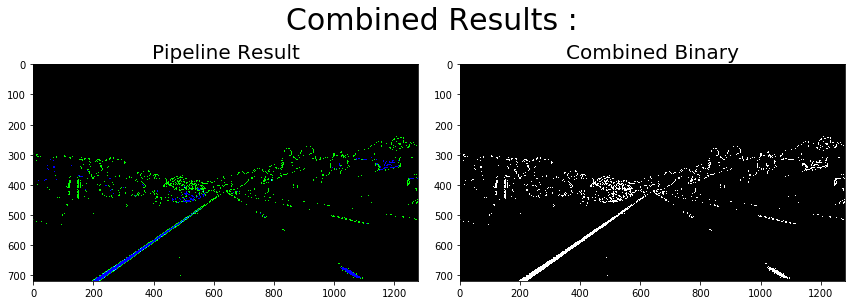

In [72]:
image = mpimg.imread('test_images/straight_lines1.jpg')
undist_img = cv2.undistort(image, mtx, dist, None, mtx)
result, sobelx_binary, schannel_binary = pipeline_gradiant_thresh(undist_img, do_plot=True)

#TODO: add to pipeline functions 
combined_binary = compine_sobel_schannel(sobelx_binary, schannel_binary, result, do_plot=True)

### 3- Perspective transform

##### 3a - adjust prespective on an image that has a straight lane line 

warped_img (720, 1280)
warped_img uint8


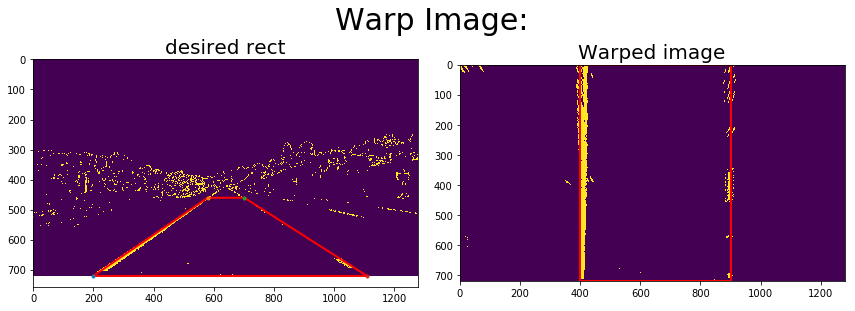

In [67]:
import matplotlib.patches as patches

def warp(image, do_plot=False):
   
    img_size = (image.shape[1], image.shape[0])
    horizon = int(img_size[1]*.64)#0.62
    
    src_vertices = np.float32(
        [[200,     img_size[1]],#LB
        [580, horizon],         #LT
        [702, horizon], 
        [1110,     img_size[1]]])
        #[[200,     img_size[1]],#LB
        #[599, horizon],         #LT
        #[678, horizon], 
        #[1110,     img_size[1]]])
    
    dst_vertices = np.float32(
        [[400, 720],
        [400, 0], 
        [900, 0], 
        [900, 720]])
        
    #warp matrix
    M = cv2.getPerspectiveTransform(src_vertices, dst_vertices)
    #unwarp matrix
    Minv = cv2.getPerspectiveTransform(dst_vertices, src_vertices)
    #do warp 
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    
    if do_plot:
        f, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
        f.tight_layout()
        f.suptitle("Warp Image:", fontsize=30)
        ax1.imshow(image)
        ax1.plot(src_vertices[0][0],src_vertices[0][1],'.')
        ax1.plot(src_vertices[1][0],src_vertices[1][1],'.')
        ax1.plot(src_vertices[2][0],src_vertices[2][1],'.')
        ax1.plot(src_vertices[3][0],src_vertices[3][1],'.')
        ax1.add_patch(patches.Polygon(src_vertices, linewidth=2, edgecolor='r', facecolor='none'))
        ax1.set_title('desired rect', fontsize=20)
        ax2.imshow(warped)
        ax2.add_patch(patches.Polygon(dst_vertices, linewidth=2, edgecolor='r', facecolor='none'))
        #ax2.add_patch(patches.Rectangle((290,0),750,720,linewidth=2,edgecolor='r',facecolor='none'))
        ax2.set_title('Warped image', fontsize=20)

    return warped, Minv

warped_img , warped_img_Minv= warp(combined_binary , do_plot=True)
print("warped_img",warped_img.shape)
print("warped_img",warped_img.dtype)

###### 3b - test same process on curved line

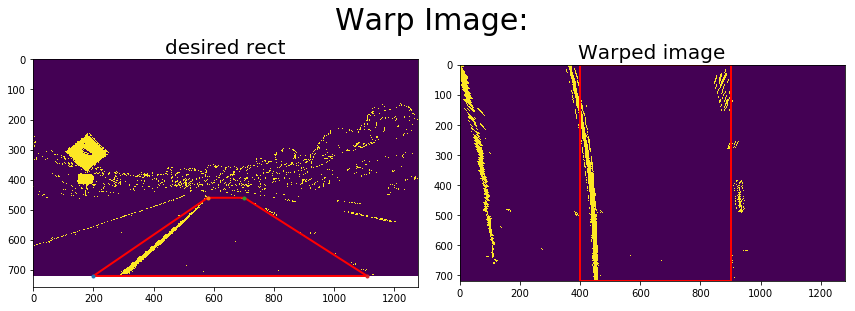

In [73]:
curved_image2 = mpimg.imread('test_images/test2.jpg')
undist_curved_image2 = cv2.undistort(curved_image2, mtx, dist, None, mtx)
curved_result2, curved_sobelx_binary2, curved_schannel_binary2 = pipeline_gradiant_thresh(undist_curved_image2, do_plot=False)

#TODO: add to pipeline functions 
curved_combined_binary2 = compine_sobel_schannel(curved_sobelx_binary2, curved_schannel_binary2,curved_result2,do_plot=False)

curved_warped_img2, curved_warped_img2_Minv = warp(curved_combined_binary2 , do_plot=True)

another test, the other way

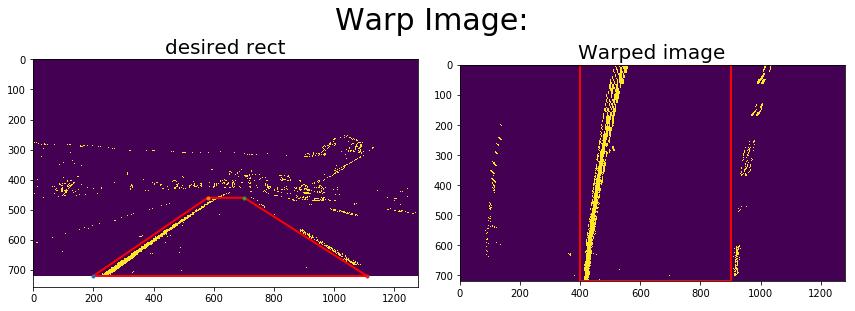

In [74]:
curved_image3 = mpimg.imread('test_images/test3.jpg')
undist_curved_image3 = cv2.undistort(curved_image3, mtx, dist, None, mtx)
curved_result3, curved_sobelx_binary3, curved_schannel_binary3 = pipeline_gradiant_thresh(undist_curved_image3, do_plot=False)

#TODO: add to pipeline functions 
curved_combined_binary3 = compine_sobel_schannel(curved_sobelx_binary3, curved_schannel_binary3,curved_result3,do_plot=False)

curved_warped_img3, curved_warped_img3_Minv = warp(curved_combined_binary3 , do_plot=True)

bright lighting conditions

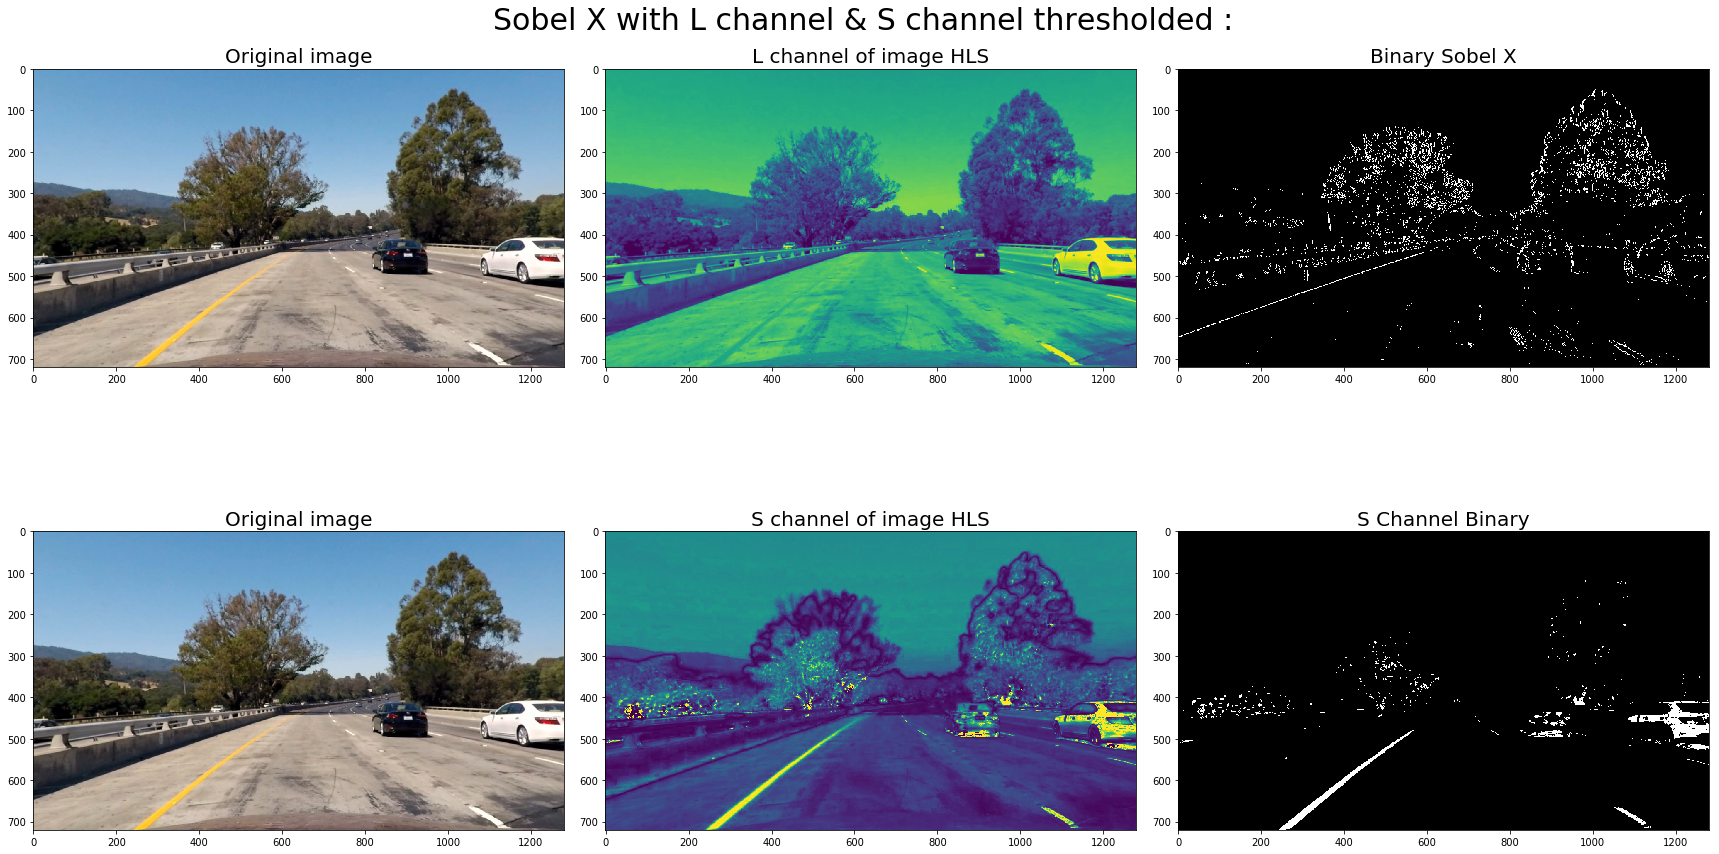

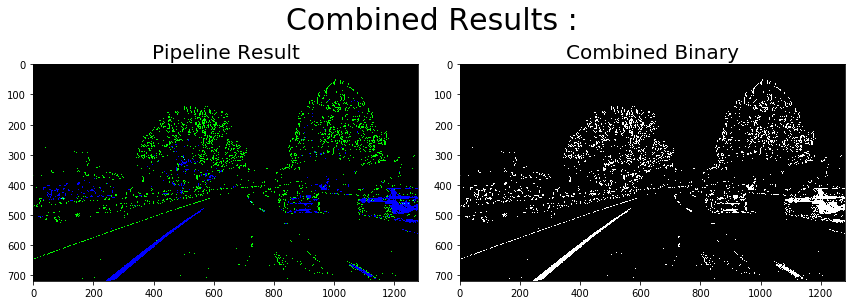

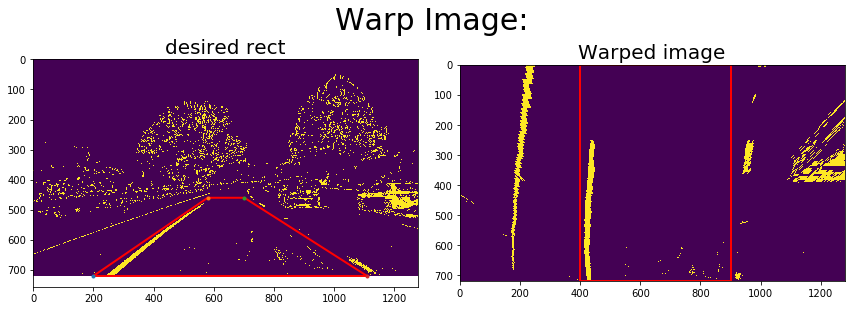

In [75]:
curved_image1 = mpimg.imread('test_images/test1.jpg')
undist_curved_image1 = cv2.undistort(curved_image1, mtx, dist, None, mtx)
curved_result1, curved_sobelx_binary1, curved_schannel_binary1 = pipeline_gradiant_thresh(undist_curved_image1, do_plot=True)

#TODO: add to pipeline functions 
curved_combined_binary1 = compine_sobel_schannel(curved_sobelx_binary1, curved_schannel_binary1, curved_result1, do_plot=True)

curved_warped_img1, curved_warped_img1_Minv = warp(curved_combined_binary1 , do_plot=True)

another crazy lighting conditions

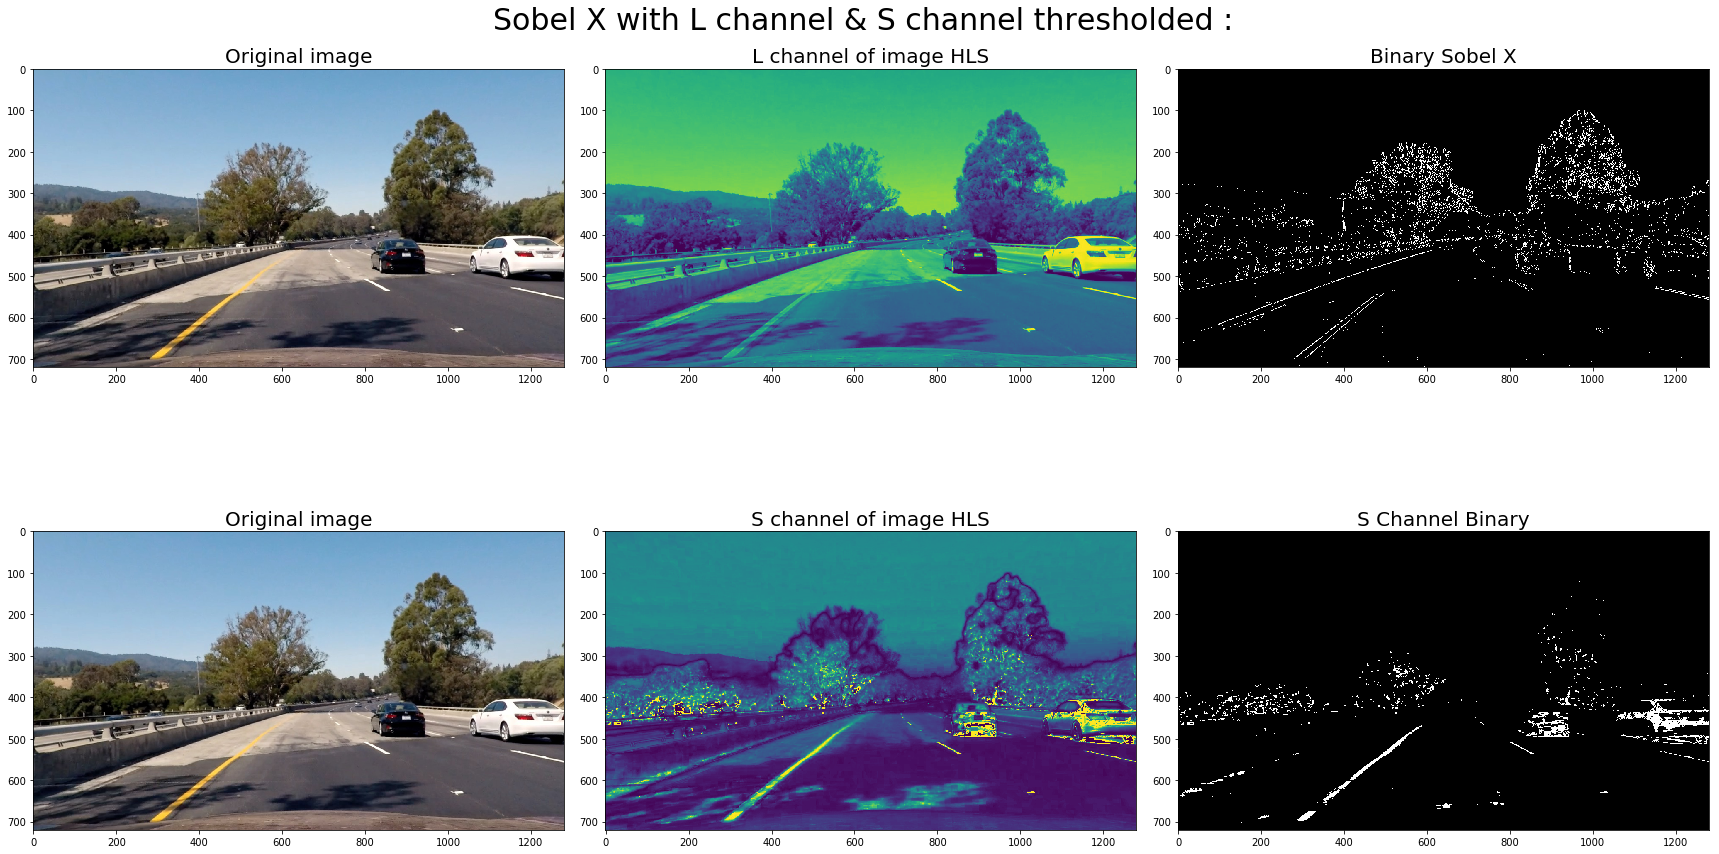

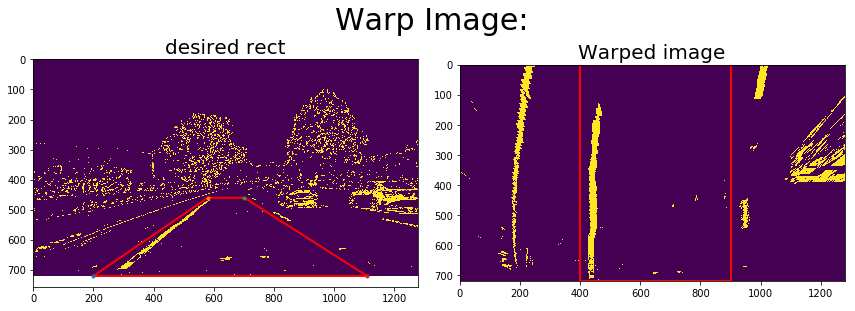

In [71]:
curved_image4 = mpimg.imread('test_images/test4.jpg')
undist_curved_image4 = cv2.undistort(curved_image4, mtx, dist, None, mtx)
curved_result4, curved_sobelx_binary4, curved_schannel_binary4 = pipeline_gradiant_thresh(undist_curved_image4, do_plot=True)

#TODO: add to pipeline functions 
curved_combined_binary4 = compine_sobel_schannel(curved_sobelx_binary4, curved_schannel_binary4, curved_result4, do_plot=False)

curved_warped_img4, curved_warped_img4_Minv = warp(curved_combined_binary4 , do_plot=True)

### 4- find the lane in the bird-eye image

dedecting lane for :
- warped_img : which is straight line
- curved_warped_img2 : clear curved to left
- curved_warped_img3 : clear curved to right
- curved_warped_img1 : confusing curved to right


C:\D\Anas\mozakra\ML\CarND013\term1\CarND-Project4_Advanced-Lane-Lines\lanesearch.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)


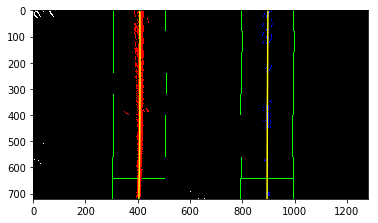

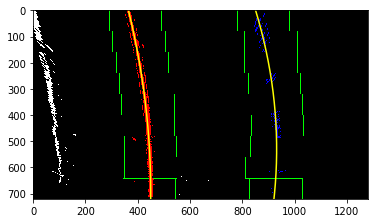

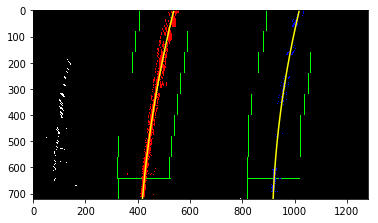

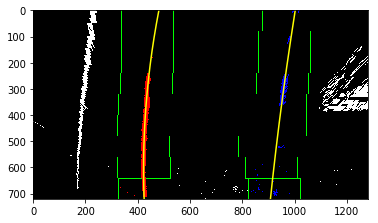

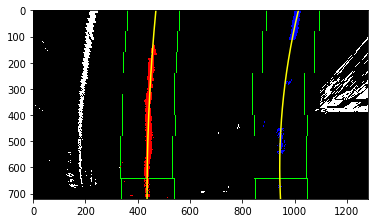

In [64]:
from lanesearch import slidingwindowsearch
warped_img_left_fit, warped_img_right_fit, ploty = slidingwindowsearch(warped_img,do_plot=True)
plt.show()
curved_warped_img2_left_fit, curved_warped_img2_right_fit, ploty2 = slidingwindowsearch(curved_warped_img2, do_plot=True)
plt.show()
curved_warped_img3_left_fit, curved_warped_img3_right_fit, ploty3 = slidingwindowsearch(curved_warped_img3, do_plot=True)
plt.show()
curved_warped_img1_left_fit, curved_warped_img1_right_fit, ploty1 = slidingwindowsearch(curved_warped_img1, do_plot=True)
plt.show()
curved_warped_img4_left_fit, curved_warped_img4_right_fit, ploty4 = slidingwindowsearch(curved_warped_img4, do_plot=True)
plt.show()

In [65]:
from curvatureandcenter import find_curvature, position_to_center

warped_img_left_curv, warped_img_right_curv = find_curvature(warped_img_left_fit, warped_img_right_fit, ploty)
curved_warped_img2_left_curv, curved_warped_img2_right_curv = find_curvature(curved_warped_img2_left_fit, curved_warped_img2_right_fit, ploty2)
curved_warped_img3_left_curv, curved_warped_img3_right_curv = find_curvature(curved_warped_img3_left_fit, curved_warped_img3_right_fit, ploty3)
curved_warped_img1_left_curv, curved_warped_img1_right_curv = find_curvature(curved_warped_img1_left_fit, curved_warped_img1_right_fit, ploty1)
curved_warped_img4_left_curv, curved_warped_img4_right_curv = find_curvature(curved_warped_img4_left_fit, curved_warped_img4_right_fit, ploty4)


find_curvature : 9366.96718943 m 52280.4231642 m
find_curvature : 928.998331341 m 574.98576102 m
find_curvature : 1467.68526199 m 1203.35931461 m
find_curvature : 1031.25428707 m 4420.90675195 m
find_curvature : 2447.05002992 m 827.752378208 m


In [66]:
position_to_center(warped_img_left_fit[-1], warped_img_right_fit[-1], 1280)
position_to_center(curved_warped_img2_left_fit[-1], curved_warped_img2_right_fit[-1], 1280)
position_to_center(curved_warped_img3_left_fit[-1], curved_warped_img3_right_fit[-1], 1280)
position_to_center(curved_warped_img1_left_fit[-1], curved_warped_img1_right_fit[-1], 1280)
position_to_center(curved_warped_img4_left_fit[-1], curved_warped_img4_right_fit[-1], 1280)

position_to_center : -0.0505352873561
position_to_center : -0.239853458316
position_to_center : -0.148004807257
position_to_center : -0.137802026091
position_to_center : -0.268718606255


-0.26871860625495819

In [ ]:
# Create an image to draw the lines on
#warp_zero = np.zeros_like(warped).astype(np.uint8)
#color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([warped_img_left_fit, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([warped_img_right_fit, plotydstackdstack])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(result, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(result, warped_img_Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
final_result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(final_result)